# Setting Up

### Import libraries

In [1]:
'''Trains a simple convnet on the MNIST dataset.
'''

from __future__ import print_function
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
set_session(sess)
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.models import model_from_json

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import os
from json import loads, dumps

Using TensorFlow backend.


### Define Hyperparameters and Paths

In [2]:
save_dir = "saved_models"
weights_name = "mnist_saved_weights_f3gen.{epoch:02d}-{val_loss:.2f}.h5"
model_json_name = "mnist_saved_f3gen.json"
batch_size = 64
num_classes = 10
epochs = 30
lr = 0.1

# input image dimensions
img_rows, img_cols = 28, 28

# Data Loading and Processing

### Load Data

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### Pre-Processing

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        validation_split = 0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

# One hot encode labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

train_gen = train_datagen.flow(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    subset = "training"
    
) 



val_gen = train_datagen.flow(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    subset = "validation"
    
) 

test_gen = test_datagen.flow(
    x = x_test, 
    y = y_test, 
    batch_size = batch_size, 
    shuffle = True
)

train_batches = train_gen.__len__()
val_batches = val_gen.__len__()
test_batches = test_gen.__len__()



# Build Neural Network

In [5]:
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.75)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

# Define Optimiser
opt = SGD(lr=lr)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Callbacks

In [6]:
mdckpt = ModelCheckpoint(
    save_dir + "/weights.{epoch:02d}-{val_loss:.2f}.hdf5", 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='auto')

callbacks = [mdckpt]

# Train

In [7]:
hist = model.fit_generator(
          train_gen,
          steps_per_epoch = train_batches/batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_gen,
          validation_steps = val_batches/batch_size,
          callbacks = callbacks
                   )

Epoch 1/30
11/10 [================================] - 6s 556ms/step - loss: 2.2535 - acc: 0.1392 - val_loss: 2.1293 - val_acc: 0.3035

Epoch 00001: val_loss improved from inf to 2.12927, saving model to saved_models/weights.01-2.13.hdf5
Epoch 2/30
11/10 [================================] - 3s 263ms/step - loss: 2.1070 - acc: 0.2315 - val_loss: 1.7519 - val_acc: 0.5224

Epoch 00002: val_loss improved from 2.12927 to 1.75190, saving model to saved_models/weights.02-1.75.hdf5
Epoch 3/30
11/10 [================================] - 3s 265ms/step - loss: 1.8130 - acc: 0.3423 - val_loss: 1.3696 - val_acc: 0.6434

Epoch 00003: val_loss improved from 1.75190 to 1.36964, saving model to saved_models/weights.03-1.37.hdf5
Epoch 4/30
11/10 [================================] - 3s 260ms/step - loss: 1.6200 - acc: 0.4517 - val_loss: 1.1005 - val_acc: 0.6971

Epoch 00004: val_loss improved from 1.36964 to 1.10048, saving model to saved_models/weights.04-1.10.hdf5
Epoch 5/30
11/10 [======================

# Save and Load Models

### Save Model and Weights

In [8]:
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# Model Definition to JSON
model_json = model.to_json()
with open(model_json_name, 'w') as json_file:
        json_file.write(model_json)

# Save Model Weights
weights_path = os.path.join(save_dir, weights_name)
model.save_weights(weights_path)

print('Saved trained weights at %s ' % weights_path)

Saved trained weights at saved_models/mnist_saved_weights_f3gen.{epoch:02d}-{val_loss:.2f}.h5 


### Load Saved Model and Weights

In [11]:
# Load Model
json_file = open(model_json_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load Weights
weights_path = os.path.join(save_dir, weights_name)
loaded_model.load_weights(weights_path)

# Compile Model
opt = SGD(lr=lr)
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Evaluation

### Keras Eval Function

In [12]:
score = model.evaluate_generator(
    test_gen, 
    steps = test_batches/batch_size, 
    verbose=1, 
    use_multiprocessing=True, 
    workers = 5)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/2 [====================================] - 0s 57ms/step
Test loss: 0.442710578442
Test accuracy: 0.854166666667


## ROC Curve

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [14]:
# Plot linewidth.
lw = 2
n_classes = num_classes

In [15]:
y_score = model.predict(x_test)

In [16]:
print(y_test[:,2].shape)
print(y_score[:,2])
y_test.shape

(10000,)
[ 0.  1.  0. ...,  0.  0.  0.]


(10000, 10)

In [17]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [18]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [19]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

### Plot ROC Curves

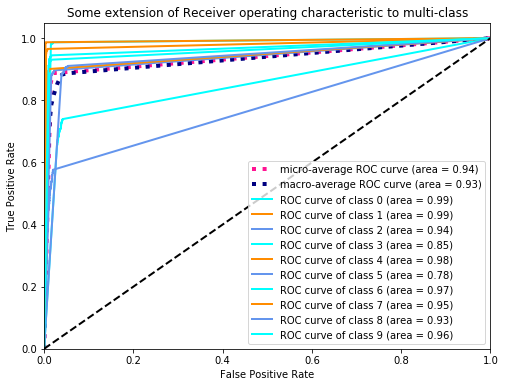

In [20]:
# Plot all ROC curves
plt.figure( figsize = (8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

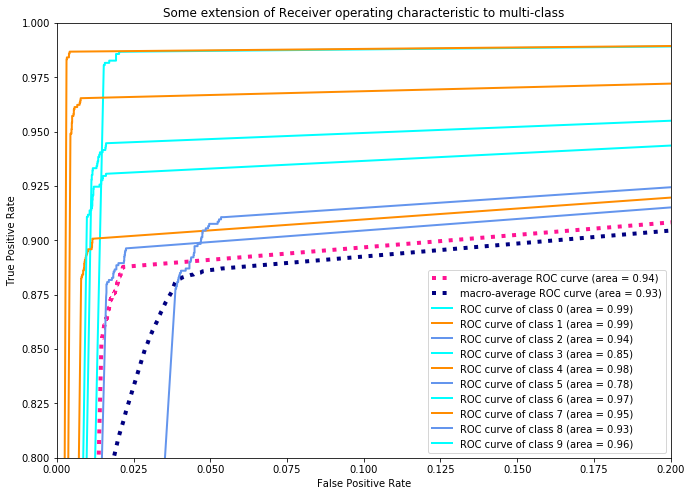

In [21]:
# Zoom in view of the upper left corner.
plt.figure( figsize = (11,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## AUC

In [22]:
roc_auc["macro"]

0.93361213510827623